In [1]:
%reload_ext autoreload
%autoreload 2

# Transport with filter compensation

## Waveform generation

In [2]:

import numpy as np
from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.functions import zpspace
from pytrans.solver import solver, init_waveform

from models.surface_trap import SurfaceTrap
from pathlib import Path

from models.surface_trap.filter import trap_filter
from pytrans.transform import TrapFilterTransform
from pytrans.transform.filter import pad_waveform

data_dir = Path('.') / 'data'


In [3]:

trap = SurfaceTrap()

axial = freq_to_curv(1e6, ion=Ca40)
rtilt = 8e7

n_samples = 80
x = zpspace(trap.x_ele(2), trap.x_ele(4), n_samples, k=5, gap=1.75)
y0 = 0
z0 = trap.z0

waveform = init_waveform(n_samples, trap.n_electrodes)
filter_transform = TrapFilterTransform(trap_filter)

# pre-compensate filters
n_pad = 15
waveform_filtered = filter_transform.transform(waveform, pad_after=n_pad)

# do not compensate filters, but apply them afterwards to evaluate the effect
# n_pad = 0
# waveform_filtered = waveform

objectives = []

# fill objectives per-step
def step_objective(voltages, x, **kwargs):
    return [
        obj.GradientObjective(voltages, trap, x, y0, z0, value=0, ion=Ca40, **kwargs),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='xx', value=axial, ion=Ca40, pseudo=False, **kwargs),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='yz', value=rtilt, ion=Ca40, pseudo=False, **kwargs),
    ]

# transport objectives for the filterd waveform
for j in range(n_samples):
    objectives += step_objective(waveform_filtered[j], x[j])
    
# repeat the objectives of the last sample
for j in range(n_pad):
    objectives += step_objective(waveform_filtered[n_samples + j], x[-1])

# voltage and slew rate constraints apply before filtering
objectives += [
    # obj.VoltageObjective(waveform, 0),
    obj.VoltageObjective(waveform, 10, constraint_type='<='),
    obj.VoltageObjective(waveform, -10, constraint_type='>='),
    # obj.SlewRateObjective(waveform, dt=trap.dt, weight=1e4),
    obj.SlewRateObjective(waveform, value=12e6, dt=trap.dt, constraint_type='<='),  # V/s
]

# constraint the first sample
# first_sample = np.load(data_dir / 'waveform_transport.npy')[0]
# objectives.append(
#     obj.VoltageObjective(waveform[0], first_sample, constraint_type="==")
# )

solver_results = solver(objectives, verbose=True)
print(solver_results['problem'].status)

_w = waveform.value
_wf = waveform_filtered.value

n_pad2 = 30
waveform = pad_waveform(_w, pad_after=n_pad2)
waveform_filtered = filter_transform.transform(_w, pad_after=n_pad2)



Compiling objectives: 100%|██████████| 288/288 [00:00<00:00, 434.02it/s]
c:\Users\carmelo\eth\projects\pytrans-examples\.venv\lib\site-packages\cvxpy\problems\problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 29 12:47:34 AM: Your problem has 960 variables, 3 constraints, and 0 parameters.
(CVXPY) Jun 29 12:47:34 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 29 12:47:34 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 29 12:47:34 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 29 12:47:34 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 29 12:47:34 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [4]:
import numpy as np
import matplotlib.pyplot as plt


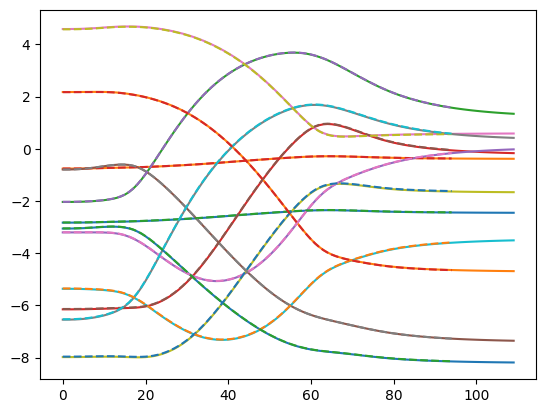

In [5]:
plt.plot(waveform_filtered);
plt.plot(_wf, '--');

## Analysis

In [6]:


from models.surface_trap import SurfaceTrap
from models.surface_trap.plot import plot_voltages_on_trap
from pytrans.analysis import analyse_potential
from pytrans.plotting.plotting import plot_potential_make_layout

from pytrans.ions import Ca40, Be9

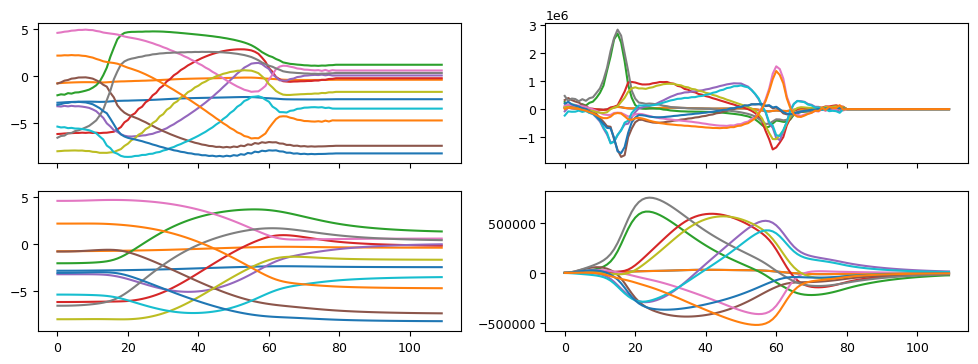

In [7]:
fig, ((ax, axg), (ax_f, axg_f)) = plt.subplots(2, 2, figsize=(12, 4), sharex=True)
ax.sharey(ax_f)
_ = ax.plot(waveform)
_ = ax_f.plot(waveform_filtered)

wg = np.gradient(waveform, axis=0) / trap.dt
axg.plot(wg)

wg_f = np.gradient(waveform_filtered, axis=0) / trap.dt
_ = axg_f.plot(wg_f)


Analyse first / middle / last sample

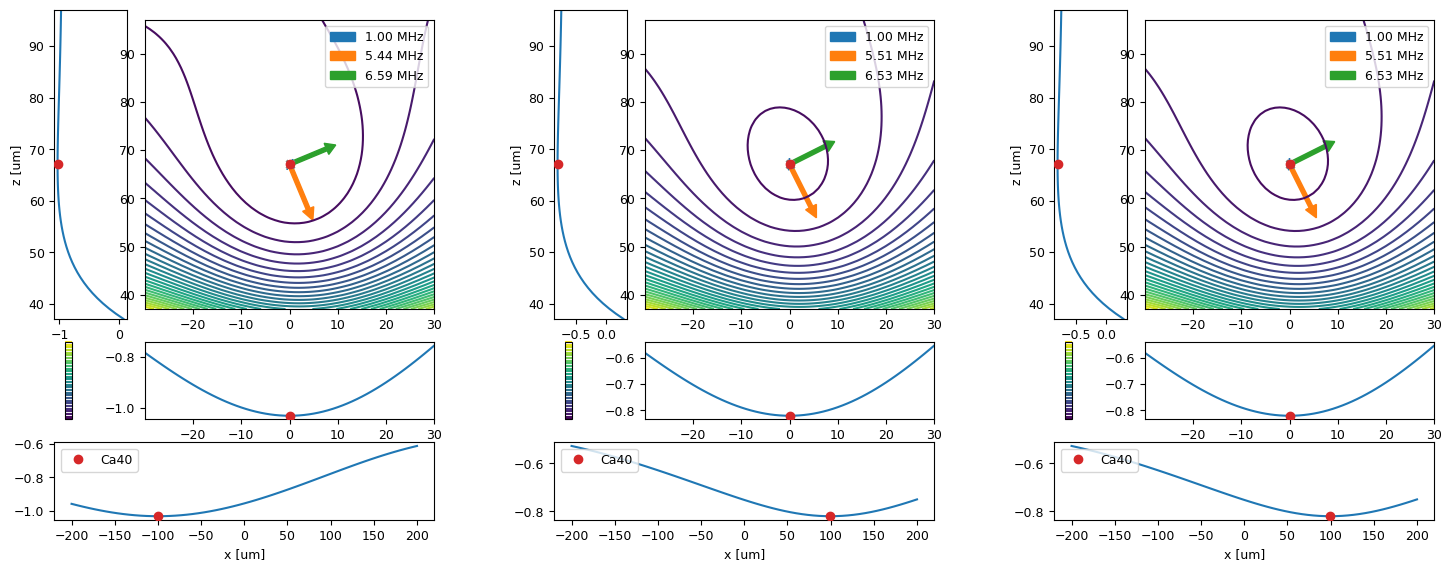

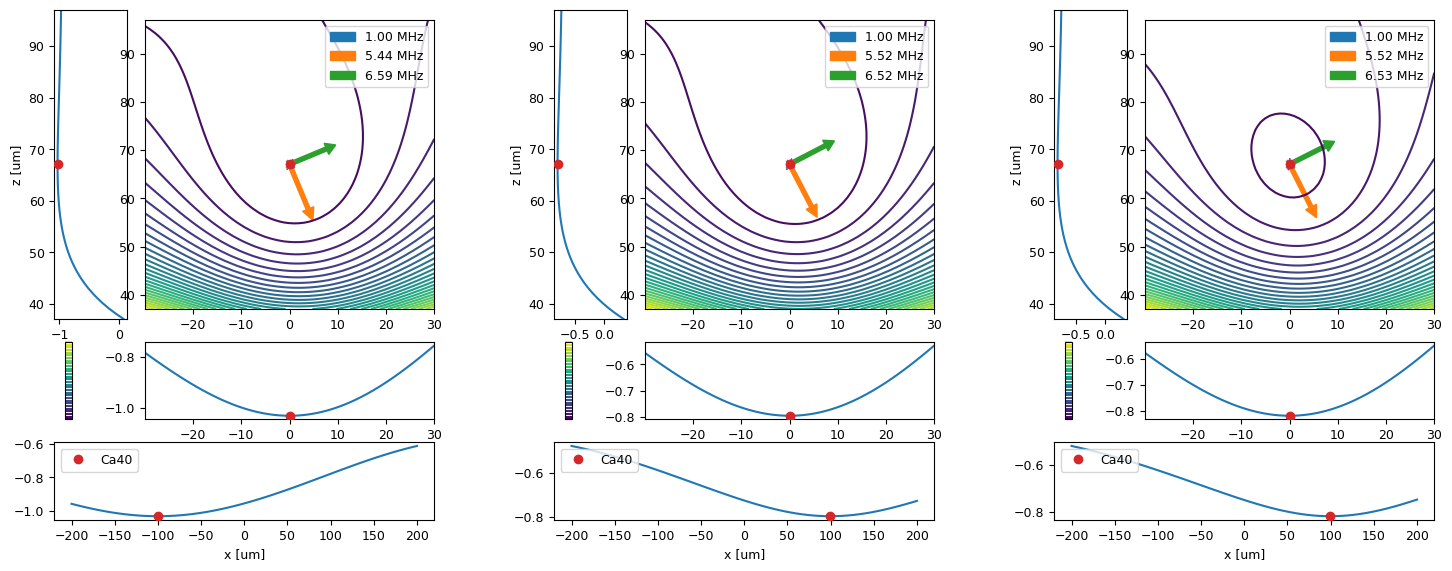

In [8]:
r0 = (0, 0, trap.z0)
roi = ((-200e-6, 200e-6), 30e-6, 30e-6)

def _analyse3(waveform, samples):
    fig, axes = plot_potential_make_layout(len(samples))
    for s, axx in zip(samples, axes):
        analyse_potential(trap, voltages=waveform[s], ions=Ca40, r0=r0, roi=roi, verbose=False, axes=axx)

samples = [0, n_samples - 1, -1]
_analyse3(waveform, samples)
_analyse3(waveform_filtered, samples)

In [9]:
from pytrans.analysis import analyse_waveform
results = analyse_waveform(trap, waveform, ions=Ca40, ion1=Ca40, r0=r0, roi=roi)
results_f = analyse_waveform(trap, waveform_filtered, ions=Ca40, ion1=Ca40, r0=r0, roi=roi)


Waveform analysis: 100%|██████████| 110/110 [00:02<00:00, 49.74it/s]


In [10]:
x_eq = np.stack([r.x_eq * 1e6 for r in results], axis=0)
freqs = np.stack([r.mode_freqs * 1e-6 for r in results], axis=0)
# x_eq2 = np.stack([r.mode_solver_results.x_eq * 1e6 for r in results], axis=0)

x_eq_f = np.stack([r.x_eq * 1e6 for r in results_f], axis=0)
freqs_f = np.stack([r.mode_freqs * 1e-6 for r in results_f], axis=0)
# x_eq2_f = np.stack([r.mode_solver_results.x_eq * 1e6 for r in results_f], axis=0)


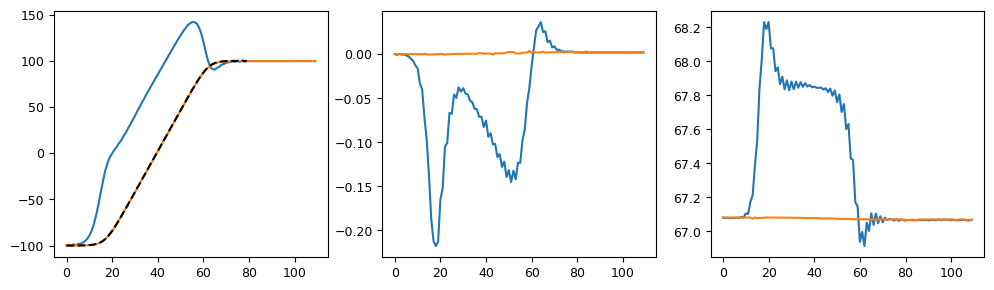

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.2), sharex=True)
for j, ax in enumerate(axes):
    ax.plot(x_eq[:, j], '-', ms=1)
    ax.plot(x_eq_f[:, j], '-', ms=1)

axes[0].plot(x * 1e6, 'k--')


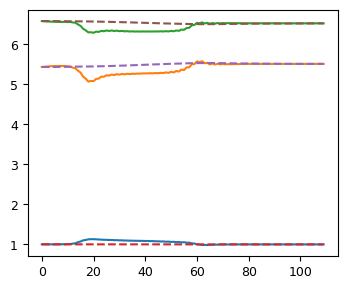

In [12]:
plt.figure(figsize=(4, 3.2))
plt.plot(freqs, '-', ms=1)
plt.plot(freqs_f, '--', ms=1)

